#### SPA6330: Artificial Intelligence and Machine Learning
#### SID: 210 287 123

# Identifying Pulsars

<hr style="border:2px solid gray">

## Problem formulation:




This project aims to classify astronomical signals as either pulsars or non-pulsars. The HTRU2 dataset [1] contains 17,898 samples, each represented by eight continuous features that describe the statistical properties of pulsar signals. These features include the mean, standard deviation, skewness, and kurtosis of the integrated pulse profile and the dispersion measure signal-to-noise ratio (DM-SNR). The dataset is well-suited for this classification problem as it provides numerical representations of the signals, which can be analysed using machine learning algorithms.

Pulsars are rapidly rotating neutron stars that emit periodic radio pulses. These emissions can be detected as repeating patterns of broadband radio signals. However, most detected signals are caused by radio frequency interference (RFI) or noise, making it challenging to identify true pulsars. [1]

Traditional manual methods are inefficient due to the vast amount of data and the similarity between real and false detections. Machine learning offers an automated approach that improves efficiency and accuracy, enabling more effective filtering out of noise and identification of true pulsars.

<hr style="border:2px solid gray">

## Data preparation and feature engineering: 



In [17]:
# Importing the libraries used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from matplotlib import rc
import pandas.plotting as pdp

from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score
from sklearn.model_selection import  StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


Since the dataset did not include headers, column names were manually added. The dataset was checked for missing and infinity instances.


The column names are:

- Profile_mean = mean of the integrated profile
- Profile_stdev = standard deviation of the integrated profile
- Profile_kurtosis = excess kurtosis of the integrated profile
- Profile_skewness = skewness of the integrated profile
- DM_mean = mean of the DM-SNR curve
- DM_stdev = standard deviation of the DM-SNR curve
- DM_kurtosis = excess kurtosis of the DM-SNR curve
- DM_skewness = skewness of the DM-SNR curve

In [18]:
# Adding the column names
column_names = [
    'Profile_mean',
    'Profile_stdev',
    'Profile_kurtosis',
    'Profile_skewness',
    'DM_mean',
    'DM_stdev',
    'DM_kurtosis',
    'DM_skewness',
    'class'
]
# Reading the dataset, and adding the headers
df = pd.read_csv('Pulsars.csv', names=column_names, header=None)

# Making sure all the data is numeric
df_numeric = df.apply(pd.to_numeric, errors='coerce')

# Checking for NaN or Inf variables
countInf = np.isinf(df_numeric).sum().sum()
countNaN = np.isnan(df_numeric).sum().sum()
print("There are {} instances of NaN in the dataset".format(countNaN))
print("There are {} instances of Infinity in the dataset".format(countInf))

print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
df.describe()

There are 1605 instances of NaN in the dataset
There are 0 instances of Infinity in the dataset
Dataset Shape: 17,898 rows × 9 columns


,Profile_mean,Profile_stdev,Profile_kurtosis,Profile_skewness,DM_mean,DM_stdev,DM_kurtosis,DM_skewness,class
count,17714.000000,17724.000000,17698.000000,17713.000000,17728.000000,17726.000000,17733.000000,17720.000000,17721.000000
mean,111.072722,46.555384,0.478851,1.771762,12.603340,26.323944,8.306363,104.875597,0.091530
std,25.630553,6.841435,1.066153,6.169866,29.454121,19.468155,4.504261,106.602560,0.288369
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.931641,42.384984,0.027044,-0.188050,1.923077,14.439656,5.787467,35.036700,0.000000
50%,115.050781,46.962388,0.223425,0.200201,2.801003,18.456693,8.437252,83.077049,0.000000
75%,127.037109,51.037710,0.473585,0.929755,5.469482,28.434022,10.703201,139.168483,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


The initial check revealed 1605 NaN instances. Given that the dataset had 17898 samples, the best approach was to remove rows containing NaN values rather than imputing them. To handle the outliers that are noticeable by the difference between the 75% percentile and maximum values, the z-score was computed, and samples with values exceeding 5 standard deviations from the mean were removed.

In [19]:
# Removing all rows with NaN variables
df.dropna(inplace=True)

# Removing the last column which serves as the target
target = df.iloc[:,-1]
target_df = df.iloc[:,-1]
df.drop(columns=[df.columns[-1]], inplace=True)

# Finding the Z-scores of the dataset
z_scores = stats.zscore(df)
# Removing all rows that have a sigma, 5 times more that the mean
filtered_df = df[(np.abs(z_scores) <5).all(axis=1)]
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns")

# Prints a table of the dataset
filtered_df.describe()

Dataset Shape: 16,353 rows × 8 columns


,Profile_mean,Profile_stdev,Profile_kurtosis,Profile_skewness,DM_mean,DM_stdev,DM_kurtosis,DM_skewness
count,15919.000000,15919.000000,15919.000000,15919.000000,15919.000000,15919.000000,15919.000000,15919.000000
mean,112.111918,46.627516,0.406847,1.262800,10.237071,25.465198,8.406456,103.956844
std,23.388770,6.427114,0.840121,4.117327,23.478481,18.600773,4.183241,94.376510
min,8.351562,26.429325,-1.876011,-1.585841,0.385452,8.618096,-2.018626,-1.976976
25%,101.507812,42.500289,0.026890,-0.189105,1.920987,14.407209,6.043369,38.623346
50%,115.226562,47.003239,0.220875,0.192589,2.765050,18.251392,8.511815,84.750089
75%,127.042969,50.982293,0.462549,0.887634,5.018395,27.191667,10.713622,139.846916
max,192.617188,78.619808,5.616803,32.602146,159.457358,110.642211,24.800006,637.010159


A correlation heatmap was plotted to identify redundant features. Features with a correlation above 0.9 were considered redundant, as they provided similar information.

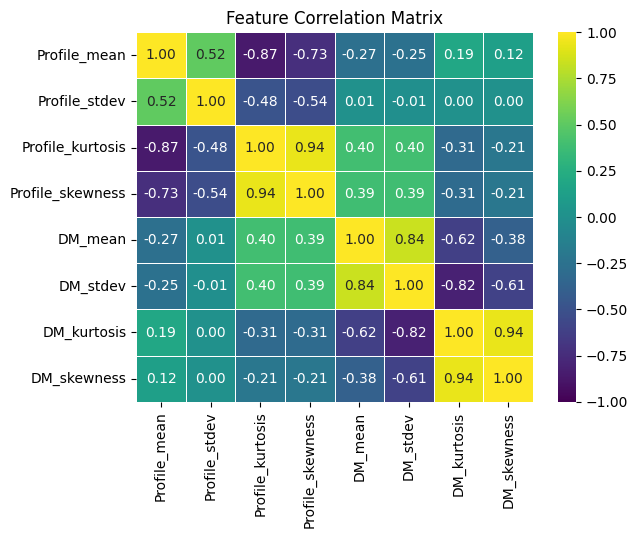

In [20]:
# Plotting a heatmap of the correlation matrix of the dataset
# Checking for highly correlated features anything above |0.90|
plt.figure()
sns.heatmap(filtered_df.corr(), annot=True, vmin=-1, vmax=1, fmt='.2f', linewidths=0.5, cmap='viridis')
plt.title('Feature Correlation Matrix')
plt.show()

Two pairs of highly correlated features were identified:

- Profile_skewness and Profile_kurtosis with correlation = 0.94
- DM_skewness and Dm_kurtosis with correlation = 0.94

To reduce redundancy, one feature from each pair was removed, ensuring that only the most relevant information was retained.

In [21]:
# Removing the features
final_features = filtered_df.drop(columns=['Profile_skewness', 'DM_kurtosis'])
final_features.describe()

# Aligning target and final_features
target = target[final_features.index]
final_features = final_features.reset_index(drop=True)
target = target.reset_index(drop=True)

<hr style="border:2px solid gray">

## Model selection and training: 



A decision tree (DT) classifier was chosen for this classification task as the dataset has a manageable size, making training time not a concern, and it can capture non-linear relationships. Decision trees also offer interpretability, making it easier to understand which features contribute to the classification. 

A decision tree recursively splits the dataset into smaller subsets by selecting the best feature at each step using the Gini impurity, defined as: [2]
$$
I_G = 1 - \sum_i f(i)^2
$$

where $f(i)$ represents the fractional abundance of each class. Splitting continues untill all nodes are pure or a predefined stopping condition is met. Predictions are made based on the majority class in each leaf node.

Advantages of decision trees include their interpretability, versatility  and minimal need for preprocessing. However, they are prone to overfitting and are sensitive to changes in the training data. [2]

Two decision tree models were trained on the dataset, with different preprocessing strategies. The first model was trained after simply removing missing values, while the second model underwent the additional data cleaning, including outlier removal and feature selection. Both models were trained using an 80/20 train-test split and evaluated using default parameters.

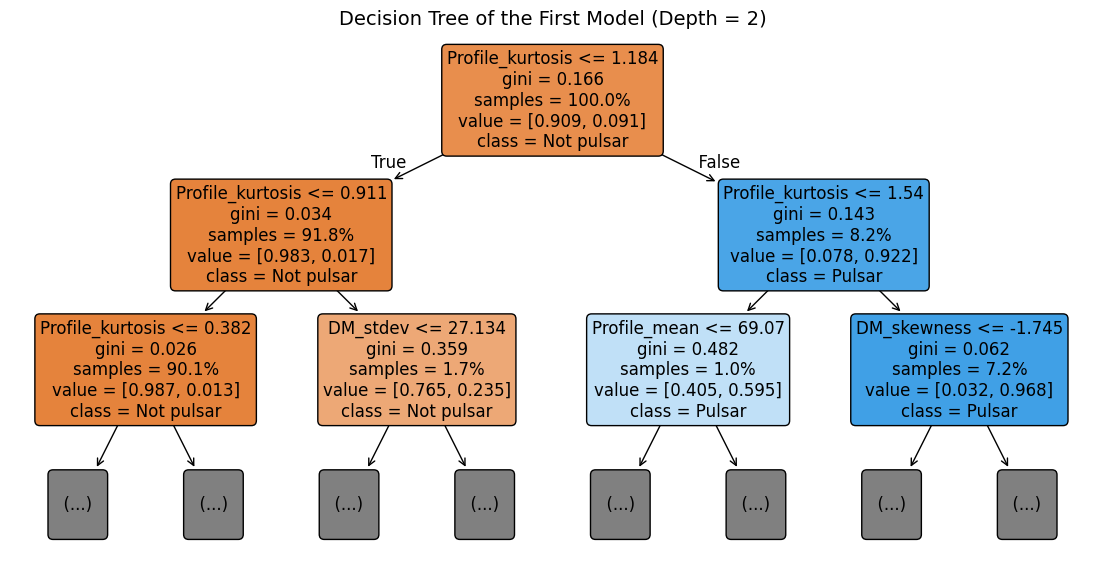

In [22]:
# Model 1
Xtrain_df, Xtest_df, ytrain_df, ytest_df = train_test_split(df, target_df, test_size=0.2, random_state=10)
model_df= DecisionTreeClassifier(random_state=10)
model_df.fit(Xtrain_df, ytrain_df)

# Model 2
Xtrain_ff, Xtest_ff, ytrain_ff, ytest_ff = train_test_split(final_features, target, test_size=0.2, random_state=10)
model_ff = DecisionTreeClassifier(random_state=10)
model_ff.fit(Xtrain_ff, ytrain_ff)

# Example tree plot
plt.figure(figsize=(14,7))
tree.plot_tree(model_df, max_depth=2, filled=True, rounded=True, 
               feature_names=df.columns, class_names=['Not pulsar', 'Pulsar'], 
               fontsize=12, impurity=True, proportion=True)
plt.title('Decision Tree of the First Model (Depth = 2)', fontsize=14)
plt.show()

The figure above shows a sample of the decision trees from the first model at a tree depth of 2. The tree starts by splitting on Profile_skewness <= 1.184, directing samples left or right. The left subtree further splits on Profile_skewness <= 0.911, while the right subtree splits on Profile_skewness. At this depth, the tree reaches decision nodes that classify samples as either pulsar or not pulsar. Each split refines the classification based on feature thresholds, progressively narrowing down the decision.

<hr style="border:2px solid gray">

## Model evaluation: 



To ensure robust performance evaluation, Stratified Cross-Validation was used, maintaining the class distribution across splits.

In [23]:
# Defining the cross-validation strategy
cv = StratifiedKFold(shuffle=True, random_state=10, n_splits=5)

In [24]:
# Perform cross-validation using the DT model and prints the metrics
def cv_metrics(features, target, title):

    # computing the metrics
    scores_acc = cross_validate(DecisionTreeClassifier(), features, target, cv=cv, scoring='accuracy', return_train_score=True)
    scores_prec = cross_validate(DecisionTreeClassifier(), features, target, cv=cv, scoring='precision', return_train_score=True)
    scores_rec = cross_validate(DecisionTreeClassifier(), features, target, cv=cv, scoring='recall', return_train_score=True)

    # Creates a string containing the evaluation metrics
    cv_metrics = f"""
    The cross-validation results for the {title} DT model are:
    
    - Train set: 
        - Accuracy: {scores_acc['train_score'].mean():.3f} ± {scores_acc['train_score'].std():.3f}
        - Precision: {scores_prec['train_score'].mean():.3f} ± {scores_prec['train_score'].std():.3f}
        - Recall: {scores_rec['train_score'].mean():.3f} ± {scores_rec['train_score'].std():.3}
    
    - Test set:
        - Accuracy: {scores_acc['test_score'].mean():.3f} ± {scores_acc['test_score'].std():.3f}
        - Precision: {scores_prec['test_score'].mean():.3f} ± {scores_prec['test_score'].std():.3f}
        - Recall: {scores_rec['test_score'].mean():.3f} ± {scores_rec['test_score'].std():.3f}
    """
    
    print(cv_metrics)
    return

cv_metrics(df, target_df, 'first')
cv_metrics(final_features, target, 'second')


    The cross-validation results for the first DT model are:
    
    - Train set: 
        - Accuracy: 1.000 ± 0.000
        - Precision: 1.000 ± 0.000
        - Recall: 1.000 ± 0.0
    
    - Test set:
        - Accuracy: 0.968 ± 0.002
        - Precision: 0.830 ± 0.018
        - Recall: 0.829 ± 0.027
    

    The cross-validation results for the second DT model are:
    
    - Train set: 
        - Accuracy: 1.000 ± 0.000
        - Precision: 1.000 ± 0.000
        - Recall: 1.000 ± 0.0
    
    - Test set:
        - Accuracy: 0.969 ± 0.002
        - Precision: 0.809 ± 0.012
        - Recall: 0.811 ± 0.015
    


From the cross-validation results, both models exhibit signs of overfitting. While their training performance was high, this did not translate to strong test performance. Notably, the second model, which underwent more extensive cleaning, performed slightly worse than the first model on test data.

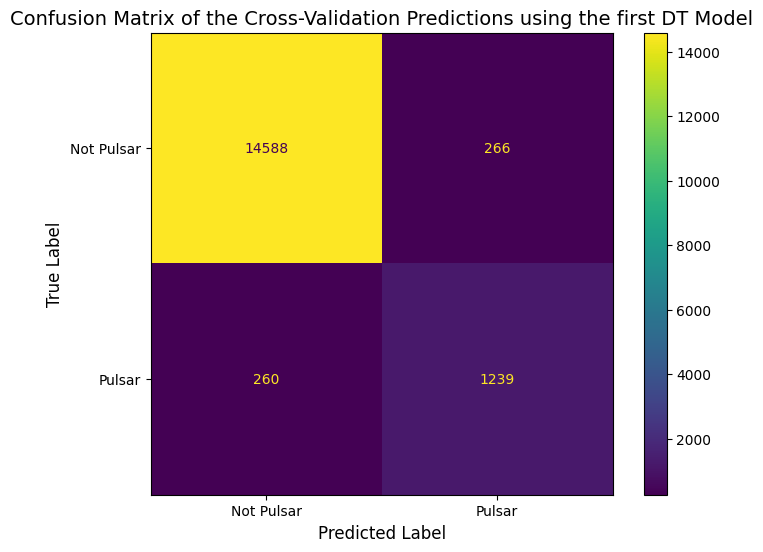


    Number of predicted pulsars using the first DT model: 1,505
    
    The confusion matrix shows:
    
    - True Negatives: 14,588
    - True Positives: 1,239
    - False Negatives: 260
    - False Positives: 266
    
    


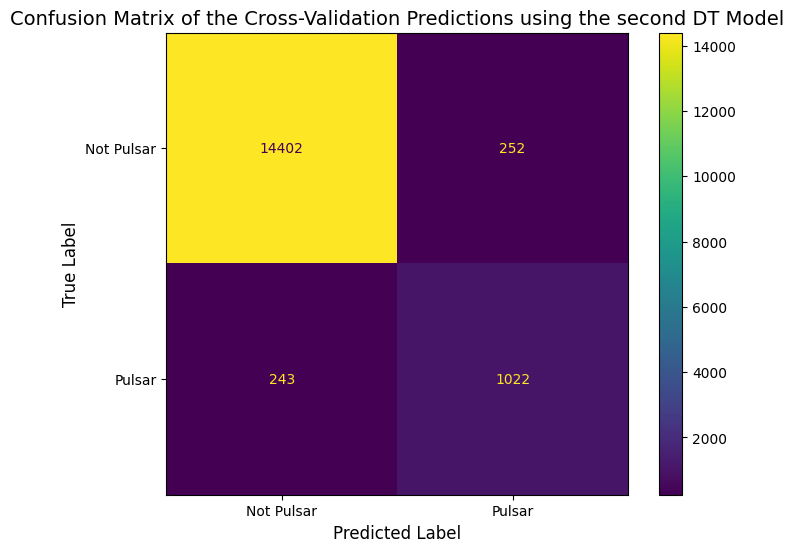


    Number of predicted pulsars using the second DT model: 1,274
    
    The confusion matrix shows:
    
    - True Negatives: 14,402
    - True Positives: 1,022
    - False Negatives: 243
    - False Positives: 252
    
    


In [25]:
# Performs cross-validation predictions and plots confusion matrices
def cv_pred(model, features, target, cv):

    # perform cross-validation predictions 
    y = cross_val_predict(model, features, target, cv=cv)

    # Generates the confusion matrix
    metrics.confusion_matrix(target,y)
    
    cm2 = metrics.confusion_matrix(target,y, labels=model.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm2,
                                   display_labels=['Not Pulsar','Pulsar'])
    fig, ax = plt.subplots(figsize=(8,6)) 
    disp.plot(cmap='viridis', ax=ax, values_format='d')

    # set the title based on which model is being used
    if model == model_df:
        title = 'first'
    else:
        title = 'second'
    
    plt.title(f'Confusion Matrix of the Cross-Validation Predictions using the {title} DT Model', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

    # Summary of results
    conf_metrics = f"""
    Number of predicted pulsars using the {title} DT model: {np.sum(y):,.0f}
    
    The confusion matrix shows:
    
    - True Negatives: {cm2[0,0]:,}
    - True Positives: {cm2[1,1]:,}
    - False Negatives: {cm2[1,0]:,}
    - False Positives: {cm2[0,1]:,}
    
    """
    
    print(conf_metrics)
    return y

yscore_df = cv_pred(model_df, df, target_df, cv)
yscore_ff = cv_pred(model_ff, final_features, target, cv)

These results indicated that the model performed well in identifying non-pulsars, and struggled with false negatives, suggesting room for improvement through hyperparameter tuning.

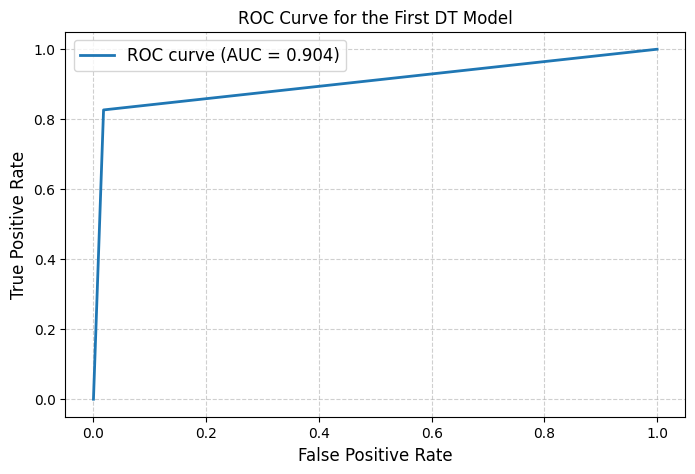

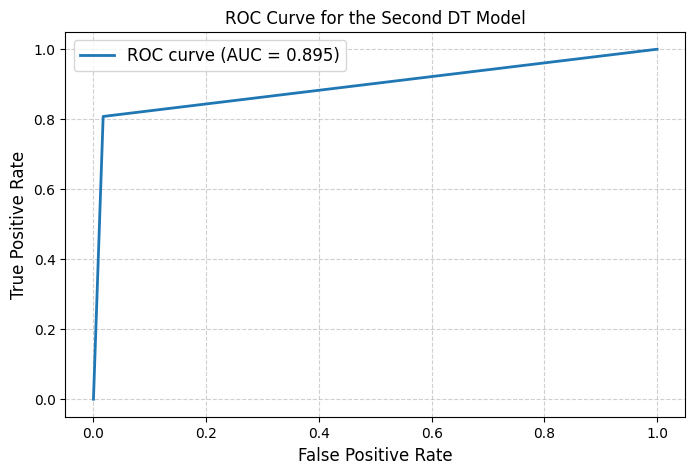

In [26]:
# Plotting ROC curves
def plot_roc(model, ytest, y_scores):

    # Labelling based on the model being used
    if model == model_df:
        label1 = 'first'
    else: 
        label1 = 'second'

    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(ytest, y_scores)
    roc_auc = auc(fpr, tpr) # computing the area under curve

    # Plotting the ROC curve
    plt.figure(figsize=(8,5))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve for the {label1.capitalize()} DT Model')
    plt.legend(loc='best', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    return

plot_roc(model_df, target_df, yscore_df)
plot_roc(model_ff, target, yscore_ff)

The Receiver Operating Characteristic (ROC) curves show that both models are good classifiers, as their curves mostly hug the top left corner. The AUC values confirm this and although both models perform similarly, the first model has a slightly better ability to distinguish between classes.

<hr style="border:2px solid gray">

## Model tuning: 


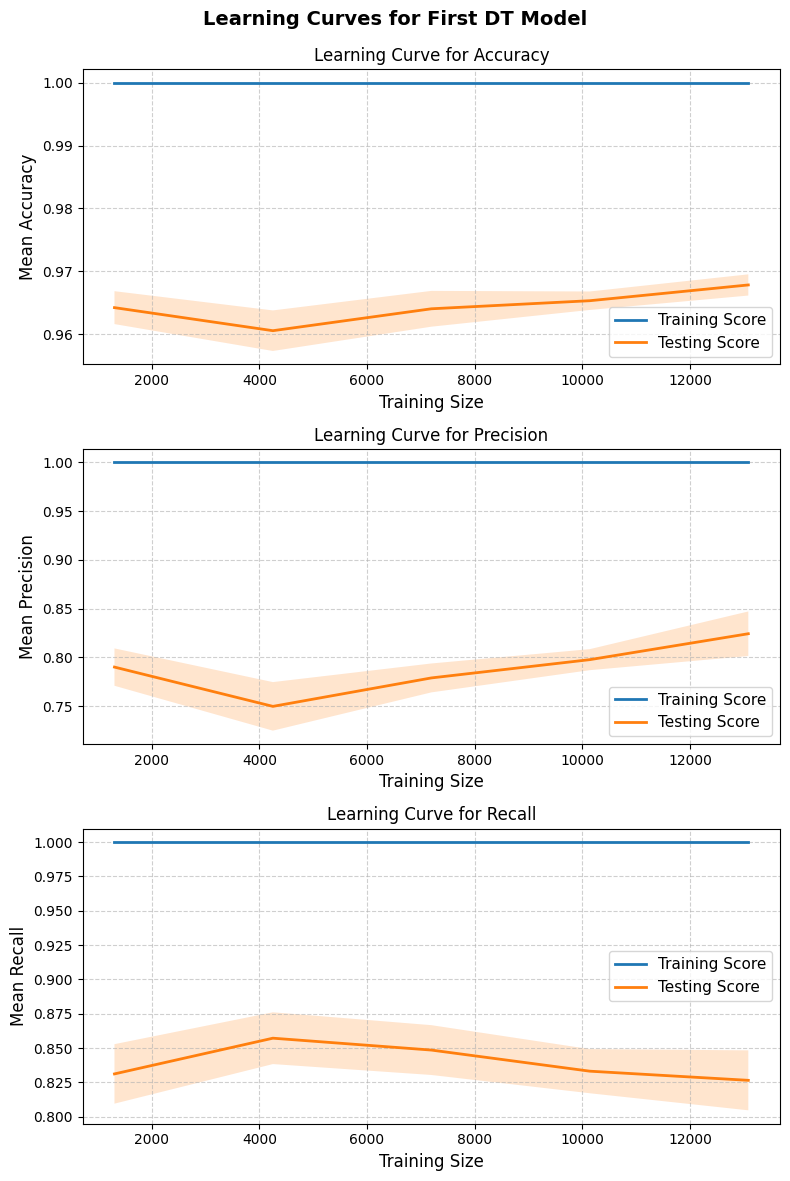

Metrics for the first DT model:


    - Accuracy:
        - Train set: Mean Accuracy: 1.000 ± 0.000
        - Test set: Mean Accuracy: 0.964 ± 0.002
        
    - Precision:
        - Train set: Mean Precision: 1.000 ± 0.000
        - Test set: Mean Precision: 0.788 ± 0.018
        
    - Recall:
        - Train set: Mean Recall: 1.000 ± 0.000
        - Test set: Mean Recall: 0.839 ± 0.019
        


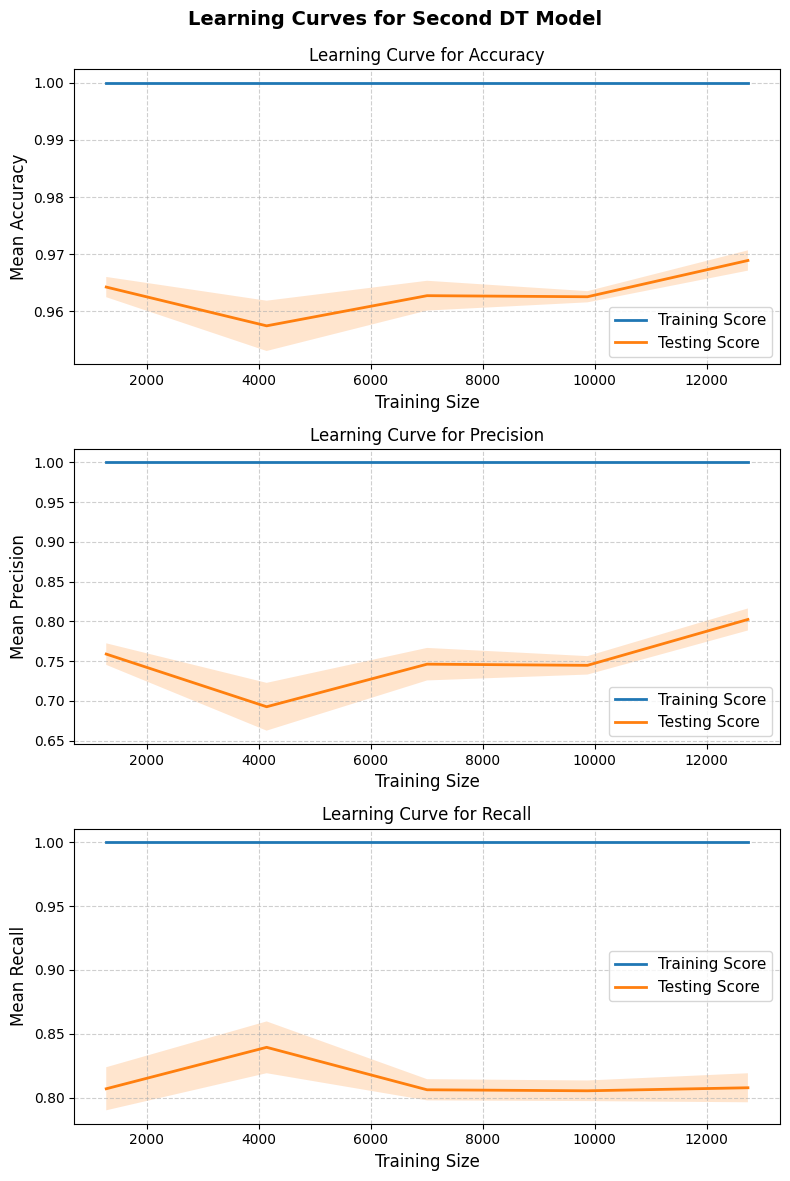

Metrics for the second DT model:


    - Accuracy:
        - Train set: Mean Accuracy: 1.000 ± 0.000
        - Test set: Mean Accuracy: 0.963 ± 0.002
        
    - Precision:
        - Train set: Mean Precision: 1.000 ± 0.000
        - Test set: Mean Precision: 0.749 ± 0.018
        
    - Recall:
        - Train set: Mean Recall: 1.000 ± 0.000
        - Test set: Mean Recall: 0.813 ± 0.013
        


In [27]:
# Plots the learning curves for the 3 scorings
def plot_learning_curve(model, features, target, title1):

    # Setting the axes
    fig, axes = plt.subplots(3, 1, figsize=(8,12))
    all_metrics = '' # creating an empty string
   
    scoring = ['accuracy', 'precision', 'recall']
    # Loops for the 3 scoring metrics
    for i, score in enumerate(scoring):
        train_sizes, train_scores, test_scores = learning_curve(
            estimator = model, 
            X = features, 
            y = target, 
            cv = StratifiedKFold(shuffle=True, random_state=10, n_splits=5), 
            train_sizes=np.linspace(0.1, 1.0, 5),
            scoring=score, 
            random_state=10
        )

        # Mean scores of the metrics
        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        
        train_std = np.std(train_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        # Generates a string to summarise the metrics
        metrics = f"""
    - {score.capitalize()}:
        - Train set: Mean {score.capitalize()}: {np.mean(train_mean):.3f} ± {np.mean(train_std):.3f}
        - Test set: Mean {score.capitalize()}: {np.mean(test_mean):.3f} ± {np.mean(test_std):.3f}
        """
        all_metrics += metrics

        # plotting the learning curve
        axes[i].plot(train_sizes, train_mean, label='Training Score', linewidth=2)
        axes[i].plot(train_sizes, test_mean, label='Testing Score', linewidth=2)
    
        axes[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
        axes[i].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
        axes[i].set_xlabel('Training Size', fontsize=12)
        axes[i].set_ylabel(f'Mean {score.capitalize()}', fontsize=12)
        axes[i].set_title(f'Learning Curve for {score.capitalize()}', fontsize=12)
        axes[i].legend(fontsize=11, loc="best")
        axes[i].grid(True, linestyle='--', alpha=0.6)

    fig.suptitle(f'Learning Curves for {title1.capitalize()} DT Model', fontsize=14, weight='bold')
    plt.tight_layout(rect=[0,0,1,.99])
    plt.show()

    print(f'Metrics for the {title1} DT model:\n')
    print(all_metrics)
    
    return

plot_learning_curve(model_df, df, target_df, 'first')
plot_learning_curve(model_ff, final_features, target, 'second')

Learning curves for accuracy, precision and recall were plotted, showing that training scores were consistently  1.0, while testing scores were lower, confirming overfitting. To address this, the key hyperparameters were fine-tuned.

In [28]:
# Checking the parameters used in the DTs
model_ff.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 10,
 'splitter': 'best'}

The decision tree model allows for several hyperparameters. The following were optimised using GridSearchCV:

- max_depth, which limits the depth of the tree to prevent overfitting.
- min_samples_leaf, which is the minimum number of samples required in a leaf node.
- min_samples_split, which is the minimum number of samples needed to split an internal node.

In [29]:
# Uses GridSearchCV to find the best hyperparameters
def find_params(model, params, features, target, Xtrain, ytrain):

    # Get labelling based on the model being used
    if model == model_df:
        title = 'first'
    else:
        title = 'second'

    # GridSearchCV to find the best hyperparameters
    model = GridSearchCV(model, params, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), 
                            return_train_score=True, verbose=1, n_jobs=4)
    model.fit(Xtrain, ytrain)

    # Extract the best hyperparameters and scores
    best_params = model.best_params_
    best_score = model.best_score_
    
    print(f'\nBest hyperparameters found for the {title} DT:')

    print(f'Best Score: {best_score:.4f}')
    print('Best Parameters:')
    for param, value in best_params.items(): # loops through the best parameters and displays them
        print(f'  - {param}: {value}')

    return best_params

# Hyperparameter grid used for the model
params = {
        'max_depth': [5, 6, 10],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 5, 10]
    }

model_df_params = find_params(model_df, params, df, target_df, Xtrain_df, ytrain_df)
model_ff_params = find_params(model_ff, params, final_features, target, Xtrain_ff, ytrain_ff)

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best hyperparameters found for the first DT:
Best Score: 0.9790
Best Parameters:
  - max_depth: 5
  - min_samples_leaf: 10
  - min_samples_split: 5
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best hyperparameters found for the second DT:
Best Score: 0.9794
Best Parameters:
  - max_depth: 5
  - min_samples_leaf: 5
  - min_samples_split: 5


In [30]:
# Fitting the best hyperparmeters in the DTs
final_model_df = DecisionTreeClassifier(**model_df_params, random_state=10)
final_model_df.fit(Xtrain_df, ytrain_df)

final_model_ff = DecisionTreeClassifier(**model_ff_params, random_state=10)
final_model_ff.fit(Xtrain_ff, ytrain_ff)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5,
                       random_state=10)

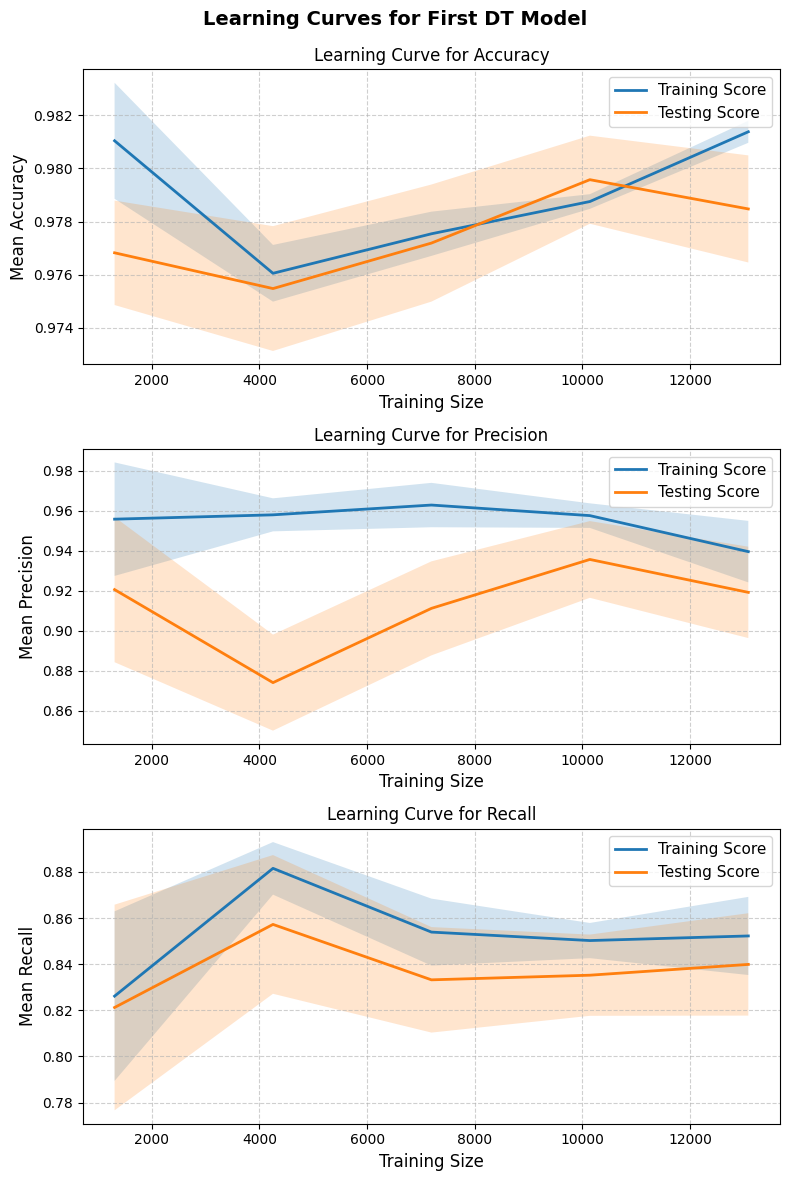

Metrics for the first DT model:


    - Accuracy:
        - Train set: Mean Accuracy: 0.979 ± 0.001
        - Test set: Mean Accuracy: 0.978 ± 0.002
        
    - Precision:
        - Train set: Mean Precision: 0.955 ± 0.014
        - Test set: Mean Precision: 0.912 ± 0.025
        
    - Recall:
        - Train set: Mean Recall: 0.853 ± 0.017
        - Test set: Mean Recall: 0.837 ± 0.027
        


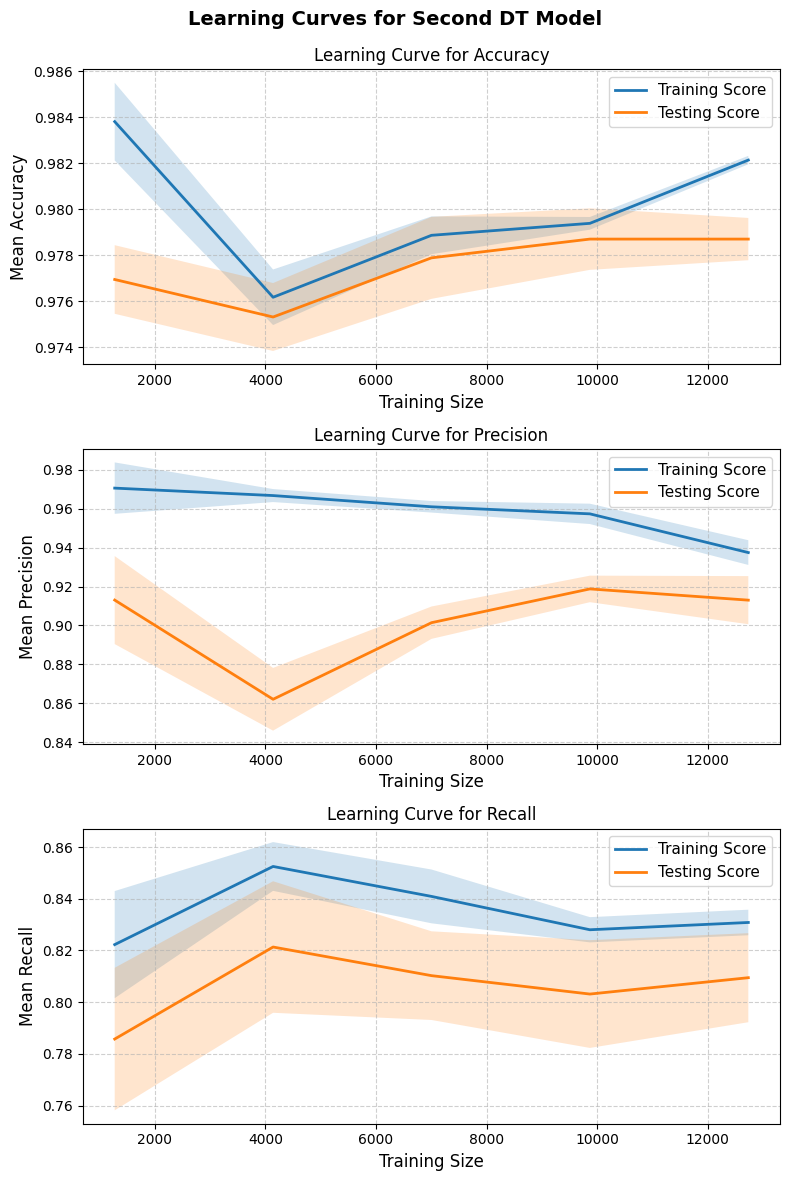

Metrics for the second DT model:


    - Accuracy:
        - Train set: Mean Accuracy: 0.980 ± 0.001
        - Test set: Mean Accuracy: 0.978 ± 0.001
        
    - Precision:
        - Train set: Mean Precision: 0.959 ± 0.006
        - Test set: Mean Precision: 0.902 ± 0.013
        
    - Recall:
        - Train set: Mean Recall: 0.835 ± 0.010
        - Test set: Mean Recall: 0.806 ± 0.022
        


In [31]:
# Learning curves of the tuned models
plot_learning_curve(final_model_df, df, target_df, 'first')
plot_learning_curve(final_model_ff, final_features, target, 'second')


After optimising the hyperparameters, both models showed improvements in generalisation. The difference between the mean train and test scores decreased, suggesting reduced overfitting.

For the first model, the recall improved from an initial mean train and test score of 1.000 and  0.839 ± 0.01, to 0.853 ± 0.017 and 0.837 ± 0.027 respectively. This indicates a slight trade off, but a more balanced and realistic performance. The second model also benefited from tuning, through its precision and recall remained lower than that of the first model.

The learning curves for both models did not show a consistent increase as the training size increased. The fluctuating trends observed suggest that pruning the training data alone may not significantly enhance performance, implying that feature engineering or model selection might be more effective areas for further improvements.

<hr style="border:2px solid gray">

## Conclusion: 




The decision tree models effectively classified astronomical signals as pulsars or non-pulsars. Initial evaluations indicated overfitting, as the models performed significantly better on the training set than on the test set. Hyperparameter tuning helped mitigate this issue, improving model generalisation slightly.

Between the two models, the first demonstrated slightly better predictive performance than the second, suggesting that the additional data cleaning steps may have had an impact. However, further experimentation is required to fully assess their effects and determine the most effective preprocessing approach.

For future work, nested cross-validation could provide a more reliable estimate of generalisation performance, reducing the risk of overfitting to the accuracy set. Additionally, feature selection techniques could be explored to optimise classification accuracy, potentially improving model interpretability and efficiency.

<hr style='border:2px solid gray'>

## References:

- [1] Lyon R. HTRU2 [dataset]. 2015. UCI Machine Learning Repository. Available from: https://doi.org/10.24432/C5DK6R
- [2] Cremonesi, L. Week_4_2025_Evaluation_Diagnostics. 2025.